<a href="https://colab.research.google.com/github/Anchita2004/CTGAN-Synthetic-Data-Generator/blob/main/CTGAN_Internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ctgan -U --force-reinstall scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

In [ ]:
# Step 1: Load and Prepare Dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load Excel file
file_path = '/content/speech-final dataset(final).xlsx'
df = pd.read_excel(file_path)

# Encode categorical columns
df = df.copy()
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Define features and target
target_col = df.columns[-1]  # Assuming the last column is the target
X = df.drop(columns=[target_col])
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine X and y into a single DataFrame for GAN training
train_data = X_train.copy()
train_data[target_col] = y_train


In [ ]:
from ctgan import CTGAN

# Identify discrete (categorical) columns, excluding target
discrete_columns = [col for col in train_data.columns if train_data[col].dtype == 'int']
discrete_columns.remove(target_col)  # exclude target from discrete columns

# Initialize and train CTGAN
ctgan = CTGAN(epochs=300)
ctgan.fit(train_data, discrete_columns)

# Generate 500 synthetic samples
synthetic_data = ctgan.sample(500)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Use only 20% of the real training data to simulate data scarcity
X_train_small = X_train.sample(frac=0.2, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# Prepare synthetic data (generated earlier)
X_synth_all = synthetic_data.drop(columns=[target_col]).reset_index(drop=True)
y_synth_all = synthetic_data[target_col].reset_index(drop=True)

# Evaluate performance by adding synthetic rows incrementally
accuracies = []
f1_scores = []
row_counts = list(range(0, 501, 50))  # 0, 50, ..., 500

for n in row_counts:
    if n == 0:
        X_train_aug = X_train_small
        y_train_aug = y_train_small
    else:
        X_synth = X_synth_all[:n]
        y_synth = y_synth_all[:n]

        X_train_aug = pd.concat([X_train_small, X_synth], ignore_index=True)
        y_train_aug = pd.concat([y_train_small, y_synth], ignore_index=True)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_aug, y_train_aug)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"Synthetic rows added: {n}, Accuracy: {acc:.4f}, F1-score: {f1:.4f}")


Synthetic rows added: 0, Accuracy: 0.8077, F1-score: 0.8387
Synthetic rows added: 50, Accuracy: 0.8462, F1-score: 0.8667
Synthetic rows added: 100, Accuracy: 0.8846, F1-score: 0.8889
Synthetic rows added: 150, Accuracy: 0.8462, F1-score: 0.8667
Synthetic rows added: 200, Accuracy: 0.8462, F1-score: 0.8667
Synthetic rows added: 250, Accuracy: 0.8462, F1-score: 0.8667
Synthetic rows added: 300, Accuracy: 0.8462, F1-score: 0.8667
Synthetic rows added: 350, Accuracy: 0.8077, F1-score: 0.8387
Synthetic rows added: 400, Accuracy: 0.7692, F1-score: 0.8125
Synthetic rows added: 450, Accuracy: 0.8077, F1-score: 0.8387
Synthetic rows added: 500, Accuracy: 0.8077, F1-score: 0.8387


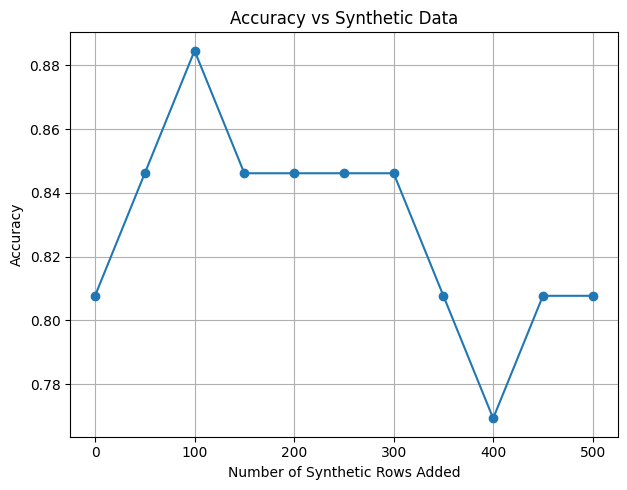

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(row_counts, accuracies, marker='o', label='Accuracy')
plt.xlabel("Number of Synthetic Rows Added")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Synthetic Data")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Step 0: Set random seeds for full reproducibility
import numpy as np
import torch
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Synthetic rows added: 0, Accuracy: 0.8077, F1-score: 0.8387
Synthetic rows added: 50, Accuracy: 0.9615, F1-score: 0.9630
Synthetic rows added: 100, Accuracy: 0.9231, F1-score: 0.9286
Synthetic rows added: 150, Accuracy: 0.9231, F1-score: 0.9286
Synthetic rows added: 200, Accuracy: 0.9231, F1-score: 0.9286
Synthetic rows added: 250, Accuracy: 0.9231, F1-score: 0.9286
Synthetic rows added: 300, Accuracy: 0.9231, F1-score: 0.9286
Synthetic rows added: 350, Accuracy: 0.9231, F1-score: 0.9286
Synthetic rows added: 400, Accuracy: 0.9615, F1-score: 0.9630
Synthetic rows added: 450, Accuracy: 0.9615, F1-score: 0.9630
Synthetic rows added: 500, Accuracy: 0.9615, F1-score: 0.9630


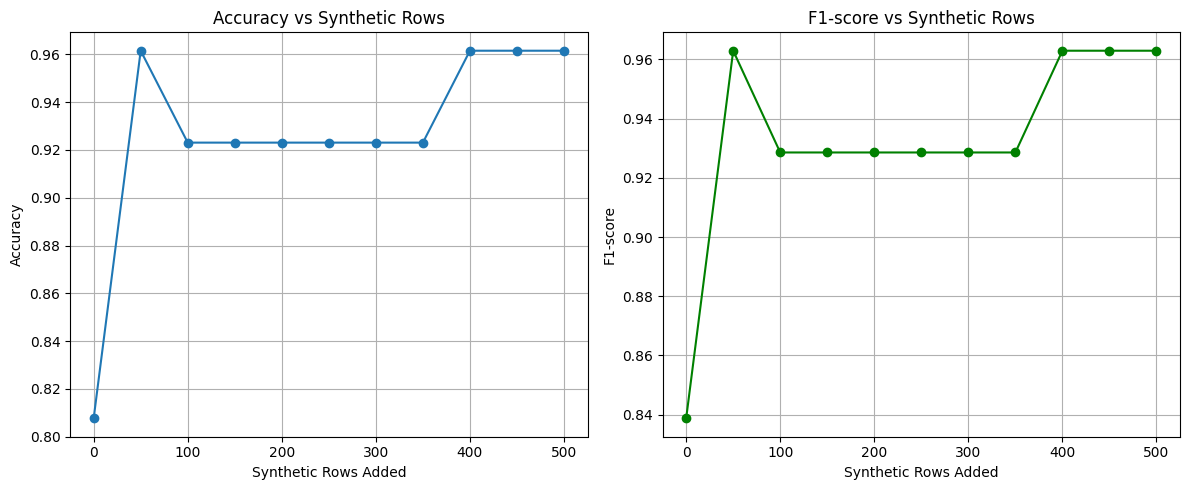

In [ ]:
# -------------------- SETUP --------------------
import pandas as pd
import numpy as np
import torch
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from ctgan import CTGAN

# -------------------- RANDOM SEED --------------------
# SEED is already defined in MDUKLkF_erLX

# -------------------- LOAD DATA --------------------

# Encode categorical columns
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# -------------------- SPLIT DATA --------------------


# Reduce real training data to 20%
X_train_small = X_train.sample(frac=0.2, random_state=SEED)
y_train_small = y_train.loc[X_train_small.index]

# -------------------- TRAIN CTGAN --------------------
discrete_columns = [col for col in train_data.columns if train_data[col].dtype == 'int']
discrete_columns.remove(target_col)

ctgan = CTGAN(epochs=300)
ctgan.fit(train_data, discrete_columns)

# -------------------- GENERATE SYNTHETIC DATA --------------------
synthetic_data = ctgan.sample(500)
X_synth_all = synthetic_data.drop(columns=[target_col]).reset_index(drop=True)
y_synth_all = synthetic_data[target_col].reset_index(drop=True)

# -------------------- EVALUATE MODEL --------------------
accuracies = []
f1_scores = []
row_counts = list(range(0, 501, 50))  # 0 to 500 in steps of 50

for n in row_counts:
    if n == 0:
        X_train_aug = X_train_small
        y_train_aug = y_train_small
    else:
        X_synth = X_synth_all[:n]
        y_synth = y_synth_all[:n]
        X_train_aug = pd.concat([X_train_small, X_synth], ignore_index=True)
        y_train_aug = pd.concat([y_train_small, y_synth], ignore_index=True)

    model = RandomForestClassifier(random_state=SEED)
    model.fit(X_train_aug, y_train_aug)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"Synthetic rows added: {n}, Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

# -------------------- PLOT RESULTS --------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(row_counts, accuracies, marker='o')
plt.title("Accuracy vs Synthetic Rows")
plt.xlabel("Synthetic Rows Added")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(row_counts, f1_scores, marker='o', color='green')
plt.title("F1-score vs Synthetic Rows")
plt.xlabel("Synthetic Rows Added")
plt.ylabel("F1-score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Combine real training data and 500 synthetic rows
X_synth_500 = X_synth_all[:500]
y_synth_500 = y_synth_all[:500]

X_final = pd.concat([X_train, X_synth_500], ignore_index=True)
y_final = pd.concat([y_train, y_synth_500], ignore_index=True)

# Combine into one DataFrame
final_df = X_final.copy()
final_df[target_col] = y_final

# Save to Excel
excel_path = '/content/synthetic_augmented_data.xlsx'
final_df.to_excel(excel_path, index=False)

# Download the file in Colab
from google.colab import files
files.download(excel_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>